Monto unità in cui è presente il dataset

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [12]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.python.keras import layers


print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
tf.config.list_physical_devices('GPU')


TF version: 2.9.2
Hub version: 0.12.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
model_name = "efficientnetv2-s" 
model_handle = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/1"
 
print(f"Selected model: {model_name} : {model_handle}")
IMAGE_SIZE = (384, 384)
print(f"Input image size {IMAGE_SIZE}")

BATCH_SIZE =  16

Selected model: efficientnetv2-s : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/1
Input image size (384, 384)


Selezione del percorso nel drive all'interno del quale si trovano le immagini di training e testing. Creazione dei DataGenerators, suddividendo il training set in validation e training e preprocessando le immagini. Definizione dei relativi set.

In [5]:
#Percorsi di training e test set
train_path="/content/gdrive/My Drive/dataset_sistemi_digitali/train"
test_path="/content/gdrive/My Drive/dataset_sistemi_digitali/test"


#Creazione data generators -> PER AUGMENTATION
train_datagen = ImageDataGenerator(validation_split= 0.1,
                                    rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

validation_set = train_datagen.flow_from_directory(train_path, 
                                                  target_size = (384, 384),
                                                  subset='validation')

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (384, 384),
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (384, 384),
                                            batch_size = 16,
                                            class_mode = 'categorical')
     

Found 174 images belonging to 6 classes.
Found 1768 images belonging to 6 classes.
Found 431 images belonging to 6 classes.


## Building and training the model


In [5]:
do_fine_tuning = False

print("Building model", model_name)
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(6,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model efficientnetv2-s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              20331360  
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 6)                 7686      
                                                                 
Total params: 20,339,046
Trainable params: 7,686
Non-trainable params: 20,331,360
_________________________________________________________________


In [6]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [7]:
hist = model.fit(
    training_set,
    epochs=20,
    validation_data=validation_set
    )
#salvataggio del modello
saved_model_path = f"/content/gdrive/My Drive/TrainedModels/saved_model_384_"
tf.saved_model.save(model, saved_model_path)



Epoch 1/20
111/111 [==============================] - 1091s 10s/step - loss: 1.0423 - accuracy: 0.7206 - val_loss: 0.8068 - val_accuracy: 0.8448
Epoch 2/20
111/111 [==============================] - 64s 578ms/step - loss: 0.7839 - accuracy: 0.8405 - val_loss: 0.7363 - val_accuracy: 0.8736
Epoch 3/20
111/111 [==============================] - 65s 581ms/step - loss: 0.7410 - accuracy: 0.8744 - val_loss: 0.7217 - val_accuracy: 0.9023
Epoch 4/20
111/111 [==============================] - 66s 594ms/step - loss: 0.7174 - accuracy: 0.8835 - val_loss: 0.7217 - val_accuracy: 0.8793
Epoch 5/20
111/111 [==============================] - 65s 582ms/step - loss: 0.7028 - accuracy: 0.8891 - val_loss: 0.6680 - val_accuracy: 0.9023
Epoch 6/20
111/111 [==============================] - 65s 585ms/step - loss: 0.6888 - accuracy: 0.8908 - val_loss: 0.6527 - val_accuracy: 0.9253
Epoch 7/20
111/111 [==============================] - 66s 594ms/step - loss: 0.6724 - accuracy: 0.9061 - val_loss: 0.6444 - val_ac

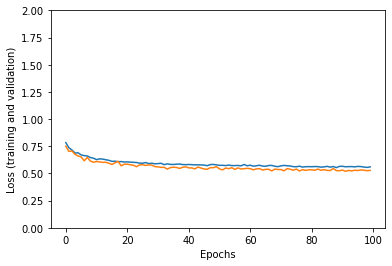

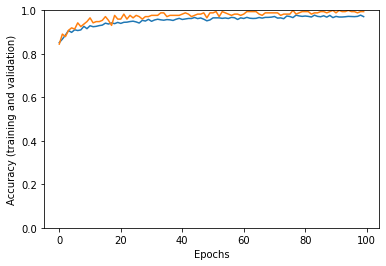

In [ ]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Epochs")
plt.ylim([0,2])
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.show()

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Epochs")
plt.ylim([0,1])
plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.show()

In [2]:
!pip install flatbuffers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:

saved_model_path = f"/content/gdrive/My Drive/TrainedModels/saved_model_384_"


Conversione del modello in TFlite, con calibrazione su 60 immagini di esempio

In [15]:
num_calibration_examples = 60 

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
lite_model_content = converter.convert()
with open(f"/content/gdrive/My Drive/TrainedModels/saved_model_384_.tflite", "wb") as f: 
  f.write(lite_model_content)
print("Wrote %sTFLite model of %d bytes." %
      ("optimized ", len(lite_model_content)))

Wrote optimized TFLite model of 21958608 bytes.


Definizione del modello tramite interprete. Definizione di una funzione Numpy to Numpy per ottenere il tensore del modello tflite

In [9]:
interpreter = tf.lite.Interpreter(model_content=lite_model_content)

def lite_model(images):
  interpreter.allocate_tensors()
  interpreter.set_tensor(interpreter.get_input_details()[0]['index'], images)
  interpreter.invoke()
  return interpreter.get_tensor(interpreter.get_output_details()[0]['index'])
     

In [10]:

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(input_details)
print(input_details)

[{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([  1, 384, 384,   3], dtype=int32), 'shape_signature': array([ -1, 384, 384,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([  1, 384, 384,   3], dtype=int32), 'shape_signature': array([ -1, 384, 384,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [ ]:
class_model = hub.load(f"/content/gdrive/My Drive/TrainedModels/saved_model_384_")
print(class_model)

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7fe84cc78340>


In [ ]:
# Get images and labels batch from validation dataset generator

val_image_batch, val_label_batch = next(iter(validation_set))
true_label_ids = np.argmax(val_label_batch, axis=-1)

print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 384, 384, 3)


In [ ]:
tf_model_predictions = class_model(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)
     

Prediction results shape: (32, 6)


In [ ]:
# Learn about dataset labels
dataset_labels = sorted(training_set.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Cardboard' 'Glass' 'Metal' 'Paper' 'Plastic' 'Trash']


In [ ]:
# Convert prediction results to Pandas dataframe, for better visualization
import pandas as pd

tf_pred_dataframe = pd.DataFrame(tf_model_predictions.numpy())
tf_pred_dataframe.columns = dataset_labels

print("Prediction results for the first elements")
tf_pred_dataframe.head()

Prediction results for the first elements


,Cardboard,Glass,Metal,Paper,Plastic,Trash
0,-1.323013,-0.387455,-0.500259,4.077470,-1.325941,-0.400750
1,-0.489773,0.122188,-0.203539,-1.215868,2.573352,-1.399200
2,0.056557,-1.558519,0.171903,2.890008,-1.008844,-0.684877
3,3.781153,-0.600266,-0.735674,-0.954539,-1.371356,-1.521031
4,-1.331427,0.129318,2.457790,-0.263588,-0.545518,-0.814447


In [ ]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]

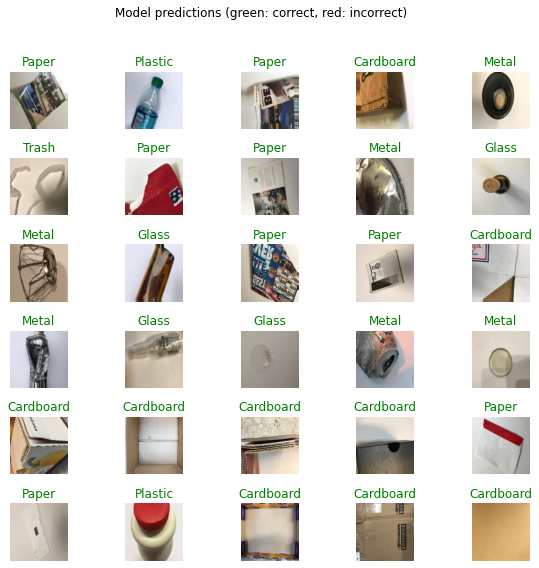

In [ ]:
# Print images batch and labels predictions

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

Quantizzazione

In [5]:
TFLITE_QUANT_MODEL = f"/content/gdrive/My Drive/TrainedModels/saved_model_384_.tflite"

In [ ]:
# Load quantized TFLite model
tflite_interpreter_quant = tf.lite.Interpreter(model_path=TFLITE_QUANT_MODEL)

# Learn about its input and output details
input_details = tflite_interpreter_quant.get_input_details()
output_details = tflite_interpreter_quant.get_output_details()

# Resize input and output tensors to handle batch of 32 images
tflite_interpreter_quant.resize_tensor_input(input_details[0]['index'], (32, 384, 384, 3))
tflite_interpreter_quant.resize_tensor_input(output_details[0]['index'], (32, 5))
tflite_interpreter_quant.allocate_tensors()

input_details = tflite_interpreter_quant.get_input_details()
output_details = tflite_interpreter_quant.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

# Run inference
tflite_interpreter_quant.set_tensor(input_details[0]['index'], val_image_batch)

tflite_interpreter_quant.invoke()

tflite_q_model_predictions = tflite_interpreter_quant.get_tensor(output_details[0]['index'])
print("\nPrediction results shape:", tflite_q_model_predictions.shape)

== Input details ==
name: serving_default_input_1:0
shape: [ 32 384 384   3]
type: <class 'numpy.float32'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [32  6]
type: <class 'numpy.float32'>

Prediction results shape: (32, 6)


In [ ]:
# Convert prediction results to Pandas dataframe, for better visualization
import pandas as pd 

tflite_q_pred_dataframe = pd.DataFrame(tflite_q_model_predictions)
tflite_q_pred_dataframe.columns = dataset_labels

print("Quantized TFLite model prediction results for the first elements")
tflite_q_pred_dataframe.head()

Quantized TFLite model prediction results for the first elements


,Cardboard,Glass,Metal,Paper,Plastic,Trash
0,-1.413736,-0.478997,-0.431160,4.168344,-1.124949,-0.738244
1,-0.513613,0.028405,-0.565839,-1.055933,2.821348,-1.205939
2,-0.004588,-1.717210,-0.189039,3.501149,-0.895238,-0.877459
3,4.587664,-0.857379,0.127435,-1.045148,-1.563811,-2.422244
4,-1.069516,0.068875,2.479791,0.015668,-0.841267,-0.882220


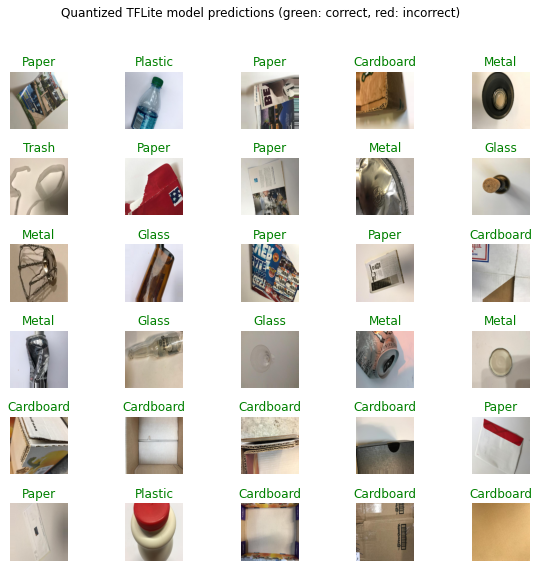

In [ ]:
# Print images batch and labels predictions for TFLite Model

tflite_q_predicted_ids = np.argmax(tflite_q_model_predictions, axis=-1)
tflite_q_predicted_labels = dataset_labels[tflite_q_predicted_ids]
tflite_q_label_id = np.argmax(val_label_batch, axis=-1)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if tflite_q_predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(tflite_q_predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Quantized TFLite model predictions (green: correct, red: incorrect)")

# ROBA IN PIÙ PER METADATI

In [ ]:
!pip install tflite-support

In [13]:
# Creates subgraph info.
from tflite_support import metadata_schema_py_generated as _metadata_fb
from tflite_support import flatbuffers
from tflite_support import metadata as _metadata

TFLITE_QUANT_MODEL = f"/content/gdrive/My Drive/TrainedModelsNew/saved_model_384_.tflite"

populator = _metadata.MetadataPopulator.with_model_file(class_model)
populator.populate()

OSError: ignored